<a href="https://colab.research.google.com/github/Gracia123/Sales-Prediction/blob/main/CS680_A5_part_3_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download data

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2020-11-09 11:48:38--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.204.34, 13.32.204.49, 13.32.204.65, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.204.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.03s   

2020-11-09 11:48:38 (95.0 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italia

In [ ]:
%matplotlib inline


Translation with a Sequence to Sequence Network and Attention
*************************************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

In this project we will be teaching a neural network to translate from
French to English.

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the `sequence
to sequence network <http://arxiv.org/abs/1409.3215>`__, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

To improve upon this model we'll use an `attention
mechanism <https://arxiv.org/abs/1409.0473>`__, which lets the decoder
learn to focus over a specific range of the input sequence.

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <http://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <http://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <http://arxiv.org/abs/1506.05869>`__

You will also find the previous tutorials on
:doc:`/intermediate/char_rnn_classification_tutorial`
and :doc:`/intermediate/char_rnn_generation_tutorial`
helpful as those concepts are very similar to the Encoder and Decoder
models, respectively.

And for more, read the papers that introduced these topics:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <http://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <http://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <http://arxiv.org/abs/1506.05869>`__


**Requirements**



In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading data files
==================

The data for this project is a set of many thousands of English to
French translation pairs.

`This question on Open Data Stack
Exchange <http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>`__
pointed me to the open translation site http://tatoeba.org/ which has
downloads available at http://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: http://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so
download to ``data/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

::

    I am cold.    J'ai froid.

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.



Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

.. figure:: /_static/img/seq-seq-images/word-encoding.png
   :alt:





We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.




In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
random.shuffle(pairs)
#train_data = pairs[0:int(math.floor(0.9*len(pairs)))]
#test_data = pairs[int(math.floor(0.9*len(pairs)))+1:]
train_data = pairs[0:int(math.floor(0.8*len(pairs)))]
validation_data = pairs[int(math.floor(0.8*len(pairs)))+1:int(math.floor(0.9*len(pairs)))]
test_data = pairs[int(math.floor(0.9*len(pairs)))+1:]

print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['notre point de vue est biaise .', 'we re biased .']


The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <http://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




Simple Decoder
^^^^^^^^^^^^^^

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

.. figure:: /_static/img/seq-seq-images/decoder-network.png
   :alt:





In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




Attention Decoder
^^^^^^^^^^^^^^^^^

If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

.. figure:: https://i.imgur.com/1152PYf.png
   :alt:

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

.. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
   :alt:





In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [ ]:
teacher_forcing_ratio = 0.5
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


teacher_forcing_ratio = 0.5
def train2(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
      
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [ ]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)  
  
def eval(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    # Without teacher forcing: use its own predictions as the next input
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length

def eval_dataset(dataset, encoder, decoder, criterion):
    loss = 0
    for pair in dataset:
        pair_tensor = tensorsFromPair(pair)
        input_tensor = pair_tensor[0]
        target_tensor = pair_tensor[1]
        loss += eval(input_tensor, target_tensor, encoder, decoder, criterion)
    return loss / len(dataset)


In [ ]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)  
  
def eval2(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    # Without teacher forcing: use its own predictions as the next input
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length

def eval_dataset2(dataset, encoder, decoder, criterion):
    loss = 0
    for pair in dataset:
        pair_tensor = tensorsFromPair(pair)
        input_tensor = pair_tensor[0]
        target_tensor = pair_tensor[1]
        loss += eval2(input_tensor, target_tensor, encoder, decoder, criterion)
    return loss / len(dataset)


The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=2000, plot_every=1000):
    start = time.time()
    all_train_losses = []
    all_validation_losses = []
    train_loss = 0  # Reset every plot_every

    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    decoder_optimizer = torch.optim.Adam(decoder.parameters())
    training_pairs = [tensorsFromPair(random.choice(train_data))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    print('\nIter \tTrain% \tTime \t\tTrain_loss')
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        train_loss += loss

        if iter % print_every == 0:
            print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every))

        if iter % plot_every == 0:
            all_train_losses.append(train_loss / plot_every)
            train_loss = 0
            
        # Compute loss based on validation data
        if iter % plot_every == 0:
            average_validation_loss = eval_dataset(validation_data, encoder, decoder, criterion)

            # save model with best validation loss
            if len(all_validation_losses) == 0 or average_validation_loss < min(all_validation_losses):
                torch.save(encoder, 'seq2seq_translation_encoder_model.pt')
                torch.save(attn_decoder, 'seq2seq_translation_attn_decoder_model.pt')
            all_validation_losses.append(average_validation_loss)

            #validation_loss = 0
            #for validation_pair in validation_data:
            #    validation_pair_tensor = tensorsFromPair(validation_pair)
            #    input_tensor = validation_pair_tensor[0]
            #    target_tensor = validation_pair_tensor[1]
            #    validation_loss += evaluate(input_tensor, target_tensor, encoder, decoder, criterion)
            #all_validation_losses.append(validation_loss / len(validation_data))
            
    return all_train_losses, all_validation_losses


def trainIters2(encoder, decoder, n_iters, print_every=2000, plot_every=1000):
    start = time.time()
    all_train_losses2 = []
    all_validation_losses2 = []
    train_loss = 0  # Reset every plot_every

    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    decoder_optimizer = torch.optim.Adam(decoder.parameters())
    training_pairs = [tensorsFromPair(random.choice(train_data))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    print('\nIter \tTrain% \tTime \t\tTrain_loss')
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train2(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        train_loss += loss

        if iter % print_every == 0:
            print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every))

        if iter % plot_every == 0:
            all_train_losses2.append(train_loss / plot_every)
            train_loss = 0
            
        # Compute loss based on validation data
        if iter % plot_every == 0:
            average_validation_loss = eval_dataset2(validation_data, encoder, decoder, criterion)

            # save model with best validation loss
            if len(all_validation_losses2) == 0 or average_validation_loss < min(all_validation_losses2):
                torch.save(encoder, 'seq2seq_translation_encoder_model_2.pt')
                torch.save(decoder, 'seq2seq_translation_decoder_model_2.pt')
            all_validation_losses2.append(average_validation_loss)

            #validation_loss = 0
            #for validation_pair in validation_data:
            #    validation_pair_tensor = tensorsFromPair(validation_pair)
            #    input_tensor = validation_pair_tensor[0]
            #    target_tensor = validation_pair_tensor[1]
            #    validation_loss += evaluate(input_tensor, target_tensor, encoder, decoder, criterion)
            #all_validation_losses.append(validation_loss / len(validation_data))
            
    #showPlot(all_train_losses_2, all_validation_losses_2)
    return all_train_losses2, all_validation_losses2

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(all_train_losses, all_validation_losses, all_train_losses2, all_validation_losses2):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(all_train_losses)
    plt.plot(all_train_losses2)
    plt.title('Seq2seq translation (training loss)')
    plt.ylabel('Negative Log Likelihood')
    plt.xlabel('# of 1000 iterations')
    plt.legend(['with attention','without attention'], loc='upper right')

    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(all_validation_losses)
    plt.plot(all_validation_losses2)
    plt.title('Seq2seq translation (validation loss)')
    plt.ylabel('Negative Log Likelihood')
    plt.xlabel('# of 1000 iterations')
    plt.legend(['with attention','without attention'], loc='upper right')


Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]


def evaluate2(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        #decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            #decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

def evaluateRandomly2(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate2(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




In [ ]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

all_train_losses, all_validation_losses = trainIters(encoder, attn_decoder, 50000) 

# evaluate on test set and print average test loss
encoder = torch.load('seq2seq_translation_encoder_model.pt')
attn_decoder = torch.load('seq2seq_translation_attn_decoder_model.pt')
average_test_loss = eval_dataset(test_data, encoder, attn_decoder, nn.NLLLoss())
print('Average test loss with attention: ' + str(average_test_loss))


Iter 	Train% 	Time 		Train_loss
2000 	4% 	(0m 53s) 	2.6979
4000 	8% 	(1m 53s) 	2.3295
6000 	12% 	(2m 52s) 	1.8828
8000 	16% 	(3m 51s) 	1.7758
10000 	20% 	(4m 50s) 	1.5920
12000 	24% 	(5m 49s) 	1.4551
14000 	28% 	(6m 49s) 	1.3022
16000 	32% 	(7m 48s) 	1.2621
18000 	36% 	(8m 48s) 	1.2742
20000 	40% 	(9m 46s) 	1.1033
22000 	44% 	(10m 46s) 	1.1013
24000 	48% 	(11m 45s) 	0.9893
26000 	52% 	(12m 44s) 	1.0136
28000 	56% 	(13m 44s) 	0.9678
30000 	60% 	(14m 43s) 	0.9315
32000 	64% 	(15m 43s) 	0.9323
34000 	68% 	(16m 42s) 	0.9305
36000 	72% 	(17m 41s) 	0.8389
38000 	76% 	(18m 40s) 	0.8937
40000 	80% 	(19m 40s) 	0.8978
42000 	84% 	(20m 39s) 	0.7806
44000 	88% 	(21m 37s) 	0.7559
46000 	92% 	(22m 37s) 	0.7692
48000 	96% 	(23m 37s) 	0.7890
50000 	100% 	(24m 36s) 	0.7147
Average test loss with attention: 2.164373018809697


In [ ]:
evaluateRandomly(encoder, attn_decoder)

> il aime beaucoup la musique .
= he is very fond of music .
< he is fond of music . <EOS>

> il a leur respect .
= he is respected by them .
< he is studying . <EOS>

> c est un magnat .
= he s a tycoon .
< he is a tycoon . <EOS>

> nous sommes en retard a cause de toi .
= we re late because of you .
< we re counting at you . <EOS>

> je ne suis pas parfait .
= i m not perfect .
< i m not perfect . <EOS>

> je suis interessee .
= i m interested .
< i m disappointed . <EOS>

> vous n etes pas normales .
= you re not normal .
< you re not normal . <EOS>

> tu es l enseignante .
= you re the teacher .
< you re the teacher . <EOS>

> c est un pigiste .
= he s a freelance journalist .
< he is a genius . <EOS>

> je ne suis pas actuellement arme .
= i m now unarmed .
< i m not here . <EOS>



In [ ]:
hidden_size = 256
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder2 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

all_train_losses2, all_validation_losses2 = trainIters2(encoder2, decoder2, 50000) 

# evaluate on test set and print average test loss
encoder2 = torch.load('seq2seq_translation_encoder_model_2.pt')
decoder2 = torch.load('seq2seq_translation_decoder_model_2.pt')
average_test_loss2 = eval_dataset2(test_data, encoder2, decoder2, nn.NLLLoss())
print('Average test loss without Attention: ' + str(average_test_loss2))


Iter 	Train% 	Time 		Train_loss
2000 	4% 	(0m 35s) 	2.7899
4000 	8% 	(1m 14s) 	2.4301
6000 	12% 	(1m 52s) 	2.0918
8000 	16% 	(2m 32s) 	1.8834
10000 	20% 	(3m 11s) 	1.7183
12000 	24% 	(3m 51s) 	1.5399
14000 	28% 	(4m 30s) 	1.4271
16000 	32% 	(5m 10s) 	1.3451
18000 	36% 	(5m 49s) 	1.2190
20000 	40% 	(6m 29s) 	1.1903
22000 	44% 	(7m 8s) 	1.0794
24000 	48% 	(7m 48s) 	1.0188
26000 	52% 	(8m 28s) 	0.9687
28000 	56% 	(9m 8s) 	0.8903
30000 	60% 	(9m 47s) 	0.8557
32000 	64% 	(10m 27s) 	0.8283
34000 	68% 	(11m 6s) 	0.7682
36000 	72% 	(11m 46s) 	0.7382
38000 	76% 	(12m 26s) 	0.7783
40000 	80% 	(13m 6s) 	0.7615
42000 	84% 	(13m 46s) 	0.6657
44000 	88% 	(14m 26s) 	0.6813
46000 	92% 	(15m 6s) 	0.6022
48000 	96% 	(15m 47s) 	0.6374
50000 	100% 	(16m 27s) 	0.6570
Average test loss without Attention: 2.2074862913490705


In [ ]:
evaluateRandomly2(encoder2, decoder2)

> vous etes fort craintif .
= you re very timid .
< you re very timid . <EOS>

> c est celui qui m a tripote .
= he s the one who touched me .
< he s the one who trained me . <EOS>

> je vais regarder la tele .
= i m going to watch tv .
< i m going to take tv . <EOS>

> je ne suis toujours pas impressionnee .
= i m still not impressed .
< i m not always impressed . <EOS>

> fais ce qu il te plait .
= you are welcome to do anything you like .
< you are looking forward to do you . <EOS>

> je ne suis pas heureux .
= i m not happy .
< i m not happy . <EOS>

> elle a deux ans de moins que moi .
= she is two years younger than me .
< she s two years older than me . <EOS>

> il est sujet a des crises de colere .
= he is subject to fits of anger .
< he is known to get . <EOS>

> je vais au lit .
= i am going to bed .
< i m going to the bed . <EOS>

> je ne suis pas malheureux .
= i m not miserable .
< i m not cranky . <EOS>



<Figure size 432x288 with 0 Axes>

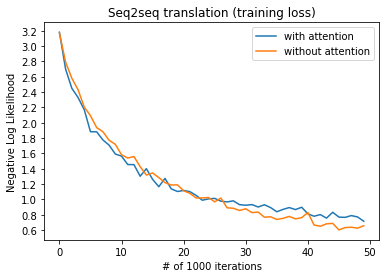

<Figure size 432x288 with 0 Axes>

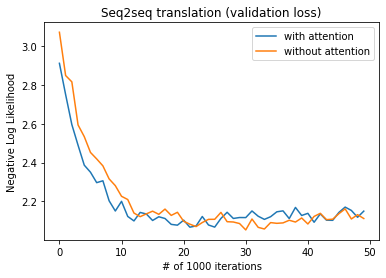

In [ ]:
showPlot(all_train_losses, all_validation_losses, all_train_losses2, all_validation_losses2)

Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




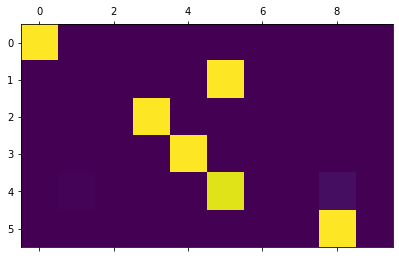

In [ ]:
output_words, attentions = evaluate(
    encoder, attn_decoder, "je suis trop froid .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




input = elle a cinq ans de moins que moi .
output = she is certainly above me . <EOS>


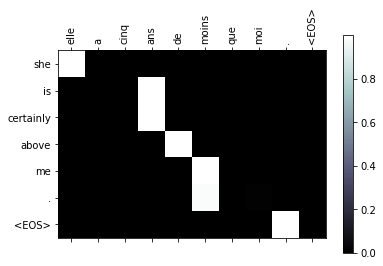

input = elle est trop petit .
output = she speaks too busy . <EOS>


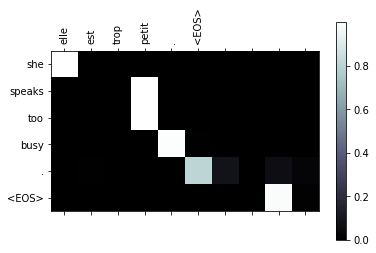

input = je ne crains pas de mourir .
output = i m not afraid of die . <EOS>


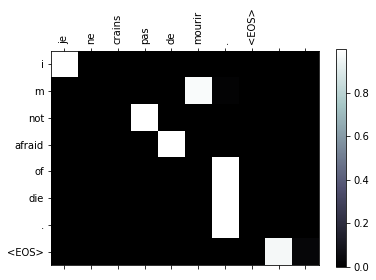

input = c est un jeune directeur plein de talent .
output = he is a talented young writer . <EOS>


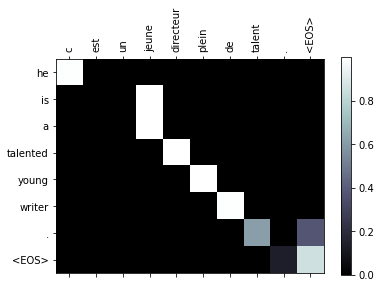

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder, attn_decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")